In [1]:
import re
import glob
import json
import numpy as np
import pandas as pd
import geopandas as gpd

from tqdm import tqdm

import plotly.express as px
import matplotlib.pyplot as plt

import plotly.io as pio
pio.renderers.default = "iframe"

In [2]:
import lightgbm as lgb

# Гео-данные станций

In [3]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

In [4]:
posts_df = pd.read_csv('../data/Датасет_04/02_координаты_станций.csv', sep=';', names=['post_name', 'latitude', 'longitude'])
posts = gpd.GeoDataFrame(
                posts_df, geometry=gpd.points_from_xy(posts_df.longitude, posts_df.latitude))

In [5]:
posts

,post_name,latitude,longitude,geometry
0,Академика,55.658163,37.471434,POINT (37.47143 55.65816)
1,Бутлерова,55.649412,37.535874,POINT (37.53587 55.64941)
2,Глебовская,55.811801,37.712490,POINT (37.71249 55.81180)
3,Коптевский,55.833222,37.525158,POINT (37.52516 55.83322)
4,Марьино,55.652695,37.751502,POINT (37.75150 55.65270)
5,Останкино,55.821154,37.612592,POINT (37.61259 55.82115)
6,Пролетарский,55.635129,37.658684,POINT (37.65868 55.63513)
7,Спиридоновка,55.759354,37.595584,POINT (37.59558 55.75935)
8,Туристская,55.856324,37.426628,POINT (37.42663 55.85632)
9,Шаболовка,55.715698,37.605238,POINT (37.60524 55.71570)


In [6]:
gpd.datasets.available

['naturalearth_cities', 'naturalearth_lowres', 'nybb']

In [7]:
ao = gpd.read_file('../data/geo/ao.geojson')
mo = gpd.read_file('../data/geo/mo.geojson')

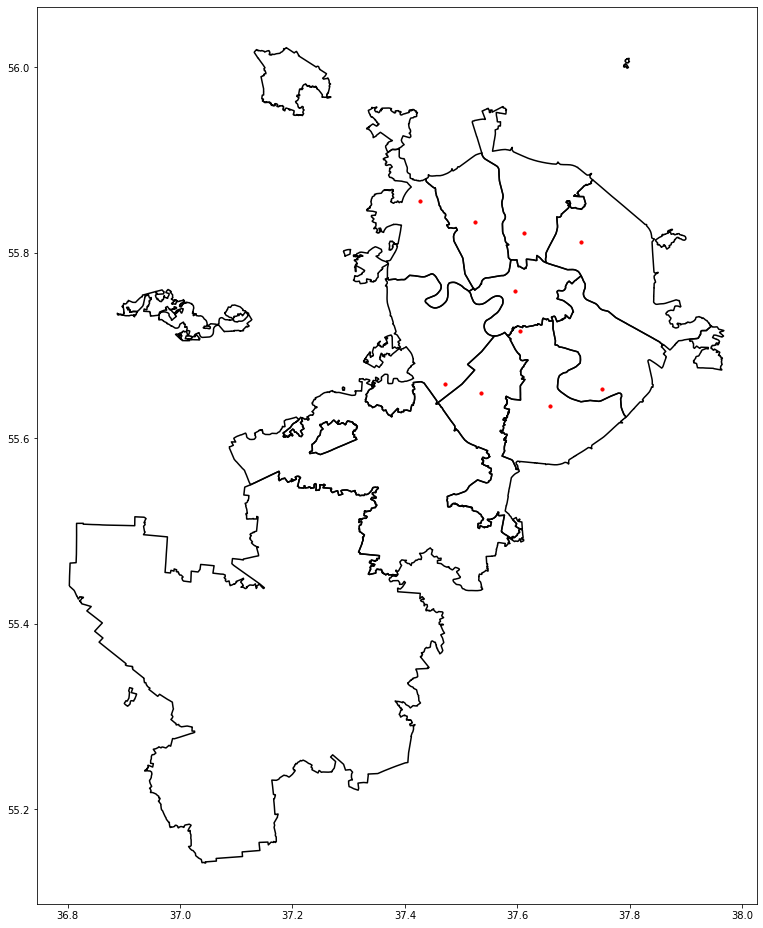

In [8]:
fig, ax = plt.subplots()

ao.boundary.plot(ax=ax, color='black', edgecolor='black')
#mo.boundary.plot(ax=ax, color='black', edgecolor='grey')
posts.plot(ax=ax, marker='o', color='red', markersize=10, aspect=1.65)
set_size(10,20)

plt.show()

# Измерения показаталей

In [9]:
datasets = {}
files = glob.glob('../data/Датасет_04/01_данные станций/[А-Я]*.xlsx')

for file in tqdm(files):
    name = re.findall(r'\w+', file)[4]
    data = pd.read_excel(file)
    data['Дата и время'] = pd.to_datetime(data['Дата и время'])
    #print(file, data.shape)
    data.dropna(subset=['Дата и время'], inplace=True)
    data.drop(data.loc[data['Дата и время'] >= '2021-01-01 00:00:00'].index, inplace=True)
    #print(file, data.shape)
    data = data.sort_values(by='Дата и время')
    datasets[name] = data

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:08<00:00,  6.82s/it]


In [10]:
def plot_report(data):
    fig, axs = plt.subplots(5)

    axs[0].plot(data['Дата и время'], data['CO'])

    axs[1].plot(data['Дата и время'], data['NO2'])
    axs[1].plot(data['Дата и время'], data['NO'])
    axs[1].plot(data['Дата и время'], data['PM10'])

    axs[2].plot(data['Дата и время'], data['Осадки'])
    axs[2].plot(data['Дата и время'], data['-T-'])
    axs[2].plot(data['Дата и время'], data['| V |'])

    axs[3].plot(data['Дата и время'], data['Давление'])

    axs[4].plot(data['Дата и время'], data['Влажность'])



    axs[0].legend(['CO'])
    axs[1].legend(['NO2', 'NO', 'PM10'])
    axs[2].legend(['Осадки', '-T-', '| V |'])
    axs[3].legend(['Давление'])
    axs[4].legend(['Влажность'])

    set_size(25,15)

In [11]:
datasets.keys()

dict_keys(['Коптевский', 'Глебовская', 'Останкино', 'Академика', 'Спиридоновка', 'Шаболовка', 'Туристская', 'Бутлерова', 'Пролетарский', 'Марьино'])

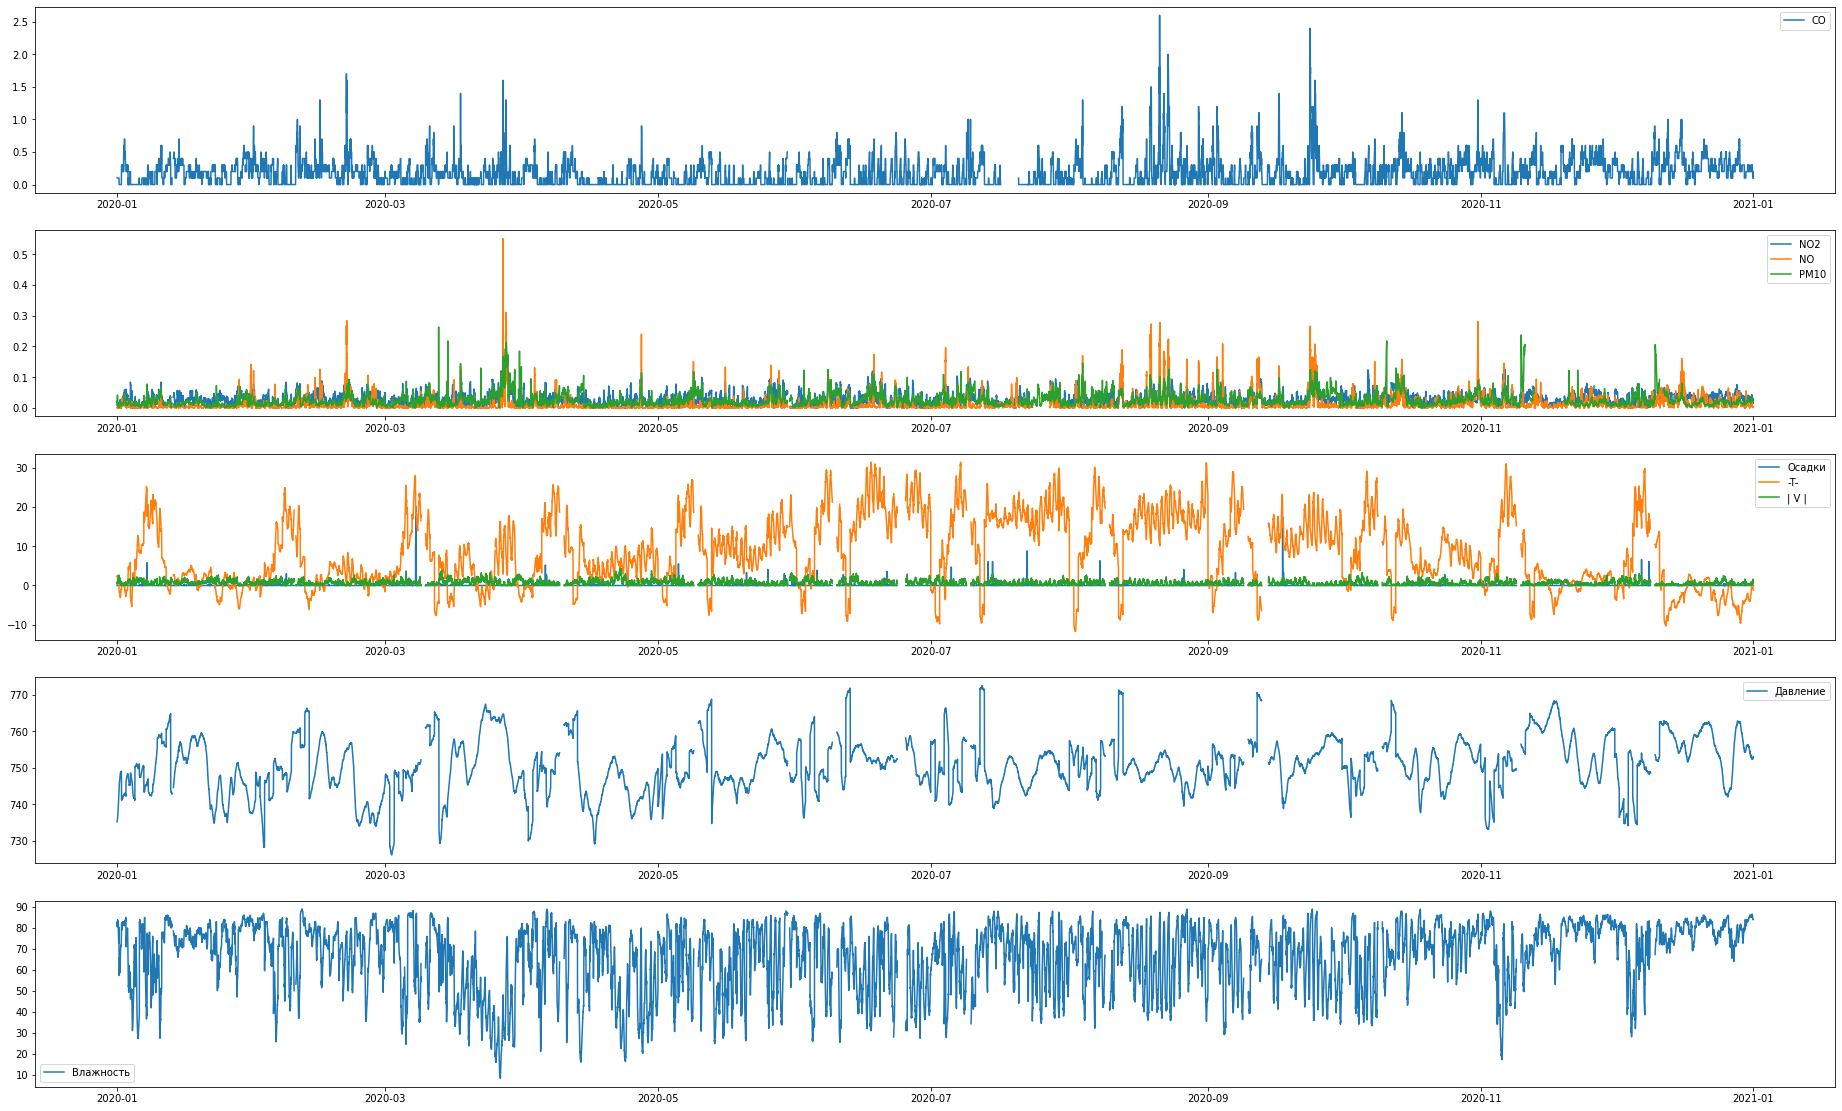

In [12]:
plot_report(datasets['Марьино'])

In [440]:
SPLIT_DT = '2021-09-24 19:00:00'
T_POST = 'Коптевский'
T_VAL = 'PM2.5'

data = datasets[T_POST].copy()
data['Дата и время'] = data['Дата и время'].dt.round('1h')
data = data.groupby(by=['Дата и время']).mean().reset_index()
data = data.reset_index(drop=True).set_index('Дата и время')
data = data[[T_VAL] +['-T-', '| V |', '_V_', 'Давление', 'Влажность', 'Осадки']]

data

,PM2.5,-T-,| V |,_V_,Давление,Влажность,Осадки
Дата и время,,,,,,,
2020-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2020-12-31 20:00:00,0.026333,0.466667,1.000000,134.000000,747.300000,92.566667,0.0
2020-12-31 21:00:00,0.022667,0.133333,0.966667,102.000000,747.466667,91.500000,0.0
2020-12-31 22:00:00,0.023667,-0.166667,0.933333,106.333333,747.600000,91.166667,0.0


'Новый год'

In [414]:
data['hour'] = data.reset_index()['Дата и время'].dt.hour.values
data['month'] = data.reset_index()['Дата и время'].dt.month.values
data['weekday'] = data.reset_index()['Дата и время'].dt.weekday.values
data['week'] = data.reset_index()['Дата и время'].dt.week.values
data['holidays'] = data.reset_index()['Дата и время'].apply(lambda r: r in list(holidays.keys())).astype(int).values

/Users/a1/Work/air_tracer/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.

/Users/a1/Work/air_tracer/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.



In [416]:
data = data.fillna(0)

In [417]:
X_train = data[:SPLIT_DT].drop([T_VAL], axis = 1)
y_train = data.loc[:SPLIT_DT, T_VAL]

X_test = data[SPLIT_DT:].drop([T_VAL], axis = 1)
y_test = data.loc[SPLIT_DT:, T_VAL]

In [421]:
bm = lgb.LGBMRegressor()
bm.fit(X_train, y_train)

LGBMRegressor()

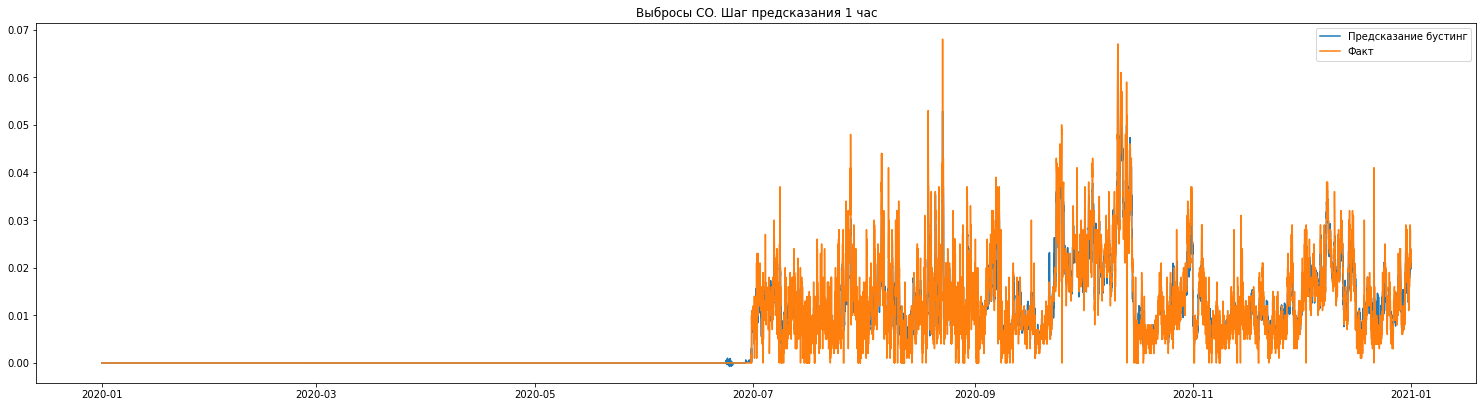

In [422]:
fig, ax = plt.subplots(1)

ax.plot(y_train.index, bm.predict(X_train))
#ax.plot(y_train.index, reg.predict(X_train))
ax.plot(y_train.index, y_train.values)
ax.legend(['Предсказание бустинг','Факт'])
ax.set_title('Выбросы CO. Шаг предсказания 1 час')

set_size(20,5)

In [451]:
mask_check = (X_train.index >= '2020-09-21 19:00:00') & (X_train.index < '2020-10-01 19:00:00')

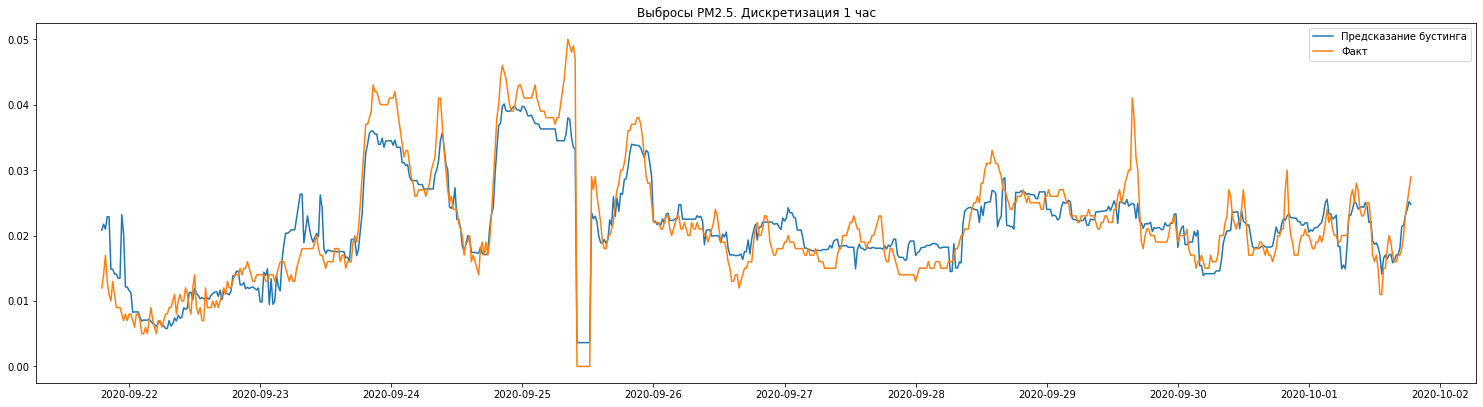

In [454]:
fig, ax = plt.subplots(1)

ax.plot(y_train.index[mask_check == True], np.abs((bm.predict(X_train[mask_check == True]))))
ax.plot(y_train.index[mask_check == True], y_train.values[mask_check == True])
ax.legend(['Предсказание бустинга', 'Факт'])
ax.set_title('Выбросы {}. Дискретизация 1 час'.format(target))

set_size(20,5)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

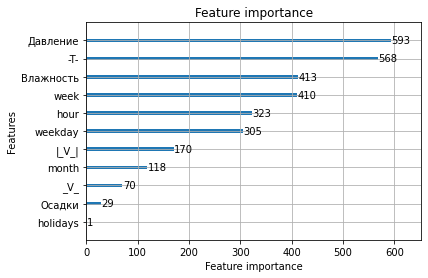

In [455]:
lgb.plot_importance(bm)

In [456]:
np.mean(np.abs(bm.predict(X_train[:])) / (y_train.values[:]+1))

0.00669004795808112

In [473]:
def  extract_feats(data):
    data['hour'] = data.reset_index()['Дата и время'].dt.hour.values
    data['month'] = data.reset_index()['Дата и время'].dt.month.values
    data['weekday'] = data.reset_index()['Дата и время'].dt.weekday.values
    data['week'] = data.reset_index()['Дата и время'].dt.week.values
    data['holidays'] = data.reset_index()['Дата и время'].apply(lambda r: r in list(holidays.keys())).astype(int).values
    return data

In [475]:
import holidays

targets = ['CO', 'NO2', 'NO', 'PM2.5', 'PM10']
holidays = holidays.CountryHoliday('RU')
holidays.get('2020-01-01')

for key in tqdm(datasets):
    data = datasets[key].copy()
    cols = data.columns.to_list()
    
    data['Дата и время'] = data['Дата и время'].dt.round('1h')
    data = data.groupby(by=['Дата и время']).mean().reset_index()
    data = data.reset_index(drop=True).set_index('Дата и время')
    
    for target in targets:
        if target in cols:
            tmp = data[ [target] + ['-T-', '| V |', '_V_', 'Давление', 'Влажность', 'Осадки'] ]
            tmp = extract_feats(tmp.copy())

  0%|                                                                                                                 | 0/10 [00:00<?, ?it/s]/Users/a1/Work/air_tracer/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.

/Users/a1/Work/air_tracer/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.13s/it]


In [481]:
pd.Timestamp.isocalendar(datasets[key]['Дата и время'].to_list()[0])

(2020, 1, 3)

In [496]:
datasets[key]['Дата и время'].apply(pd.Timestamp.isocalendar)

1         (2020, 1, 3)
2         (2020, 1, 3)
3         (2020, 1, 3)
4         (2020, 1, 3)
5         (2020, 1, 3)
             ...      
26348    (2020, 53, 4)
26349    (2020, 53, 4)
26350    (2020, 53, 4)
26351    (2020, 53, 4)
26352    (2020, 53, 4)
Name: Дата и время, Length: 26352, dtype: object

In [489]:
week

array([(2020, 1, 3), (2020, 1, 3), (2020, 1, 3), ..., (2020, 53, 4),
       (2020, 53, 4), (2020, 53, 4)], dtype=object)